# Task 2 - Character level LSTM

In [1]:
# importing all the dependencies

import numpy as np
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
plt.style.use('seaborn-white')

In [2]:
# reading the text files.

f = open("Text_1.txt","r")

if(f.mode == "r"):
    contents1 = f.read()
f.close()

f = open("Text_2.txt","r")

if(f.mode == "r"):
    contents2 = f.read()
f.close()

f = open("Text_4.txt","r")

if(f.mode == "r"):
    contents3 = f.read()
f.close()


In [3]:
# concatenating the texts
data = contents1+contents2+contents3

In [4]:
# changing upper case to lower case
data = data.lower()

In [5]:
#Process data and calculate indexes

chars = list(set(data))
data_size, X_size = len(data), len(chars)
print("data has %d characters, %d unique" % (data_size, X_size))
char_to_idx = {ch:i for i,ch in enumerate(chars)}
idx_to_char = {i:ch for i,ch in enumerate(chars)}

data has 1158620 characters, 68 unique


In [6]:
# Constants and hyper-params

H_size = 100 # Size of the hidden layer
T_steps = 25 # Number of time steps (length of the sequence) used for training
learning_rate = 0.5 # Learning rate
weight_sd = 0.1 # Standard deviation of weights for initialization
z_size = H_size + X_size # Size of concatenate(H, X) vector

In [7]:
# function for sigmoid activation
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# function for differentiation of sigmoid
def dsigmoid(y):
    return y * (1 - y)

# function for tanh activation 
def tanh(x):
    return np.tanh(x)

# function for differentiation of tanh
def dtanh(y):
    return 1 - y * y

In [8]:
# Parameters
# We use random weights with normal distribution (0, weight_sd) for  tanh  activation function 
# and (0.5, weight_sd) for  sigmoid  activation function.
# Biases are initialized to zeros.
class Param:
    def __init__(self, name, value):
        self.name = name
        self.v = value #parameter value
        self.d = np.zeros_like(value) #derivative
        self.m = np.zeros_like(value) #momentum for AdaGrad
        
class Parameters:
    def __init__(self):
        self.W_f = Param('W_f', 
                         np.random.randn(H_size, z_size) * weight_sd + 0.5)
        self.b_f = Param('b_f',
                         np.zeros((H_size, 1)))

        self.W_i = Param('W_i',
                         np.random.randn(H_size, z_size) * weight_sd + 0.5)
        self.b_i = Param('b_i',
                         np.zeros((H_size, 1)))

        self.W_C = Param('W_C',
                         np.random.randn(H_size, z_size) * weight_sd)
        self.b_C = Param('b_C',
                         np.zeros((H_size, 1)))

        self.W_o = Param('W_o',
                         np.random.randn(H_size, z_size) * weight_sd + 0.5)
        self.b_o = Param('b_o',
                         np.zeros((H_size, 1)))

        #For final layer to predict the next character
        self.W_v = Param('W_v',
                         np.random.randn(X_size, H_size) * weight_sd)
        self.b_v = Param('b_v',
                         np.zeros((X_size, 1)))
        
    def all(self):
        return [self.W_f, self.W_i, self.W_C, self.W_o, self.W_v,
               self.b_f, self.b_i, self.b_C, self.b_o, self.b_v]
        
parameters = Parameters()

In [9]:
# function for forward propagation in cell

def forward(x, h_prev, C_prev, p = parameters):
    assert x.shape == (X_size, 1)
    assert h_prev.shape == (H_size, 1)
    assert C_prev.shape == (H_size, 1)
    
    z = np.row_stack((h_prev, x))
    f = sigmoid(np.dot(p.W_f.v, z) + p.b_f.v)
    i = sigmoid(np.dot(p.W_i.v, z) + p.b_i.v)
    C_bar = tanh(np.dot(p.W_C.v, z) + p.b_C.v)

    C = f * C_prev + i * C_bar
    o = sigmoid(np.dot(p.W_o.v, z) + p.b_o.v)
    h = o * tanh(C)

    v = np.dot(p.W_v.v, h) + p.b_v.v
    #softmax function
    y = np.exp(v) / np.sum(np.exp(v)) 

    return z, f, i, C_bar, C, o, h, v, y

In [10]:
# function  for backward propagation

def backward(target, dh_next, dC_next, C_prev,
             z, f, i, C_bar, C, o, h, v, y,
             p = parameters):
    
    assert z.shape == (X_size + H_size, 1)
    assert v.shape == (X_size, 1)
    assert y.shape == (X_size, 1)
    
    for param in [dh_next, dC_next, C_prev, f, i, C_bar, C, o, h]:
        assert param.shape == (H_size, 1)
        
    dv = np.copy(y)
    dv[target] -= 1

    p.W_v.d += np.dot(dv, h.T)
    p.b_v.d += dv

    dh = np.dot(p.W_v.v.T, dv)        
    dh += dh_next
    do = dh * tanh(C)
    do = dsigmoid(o) * do
    p.W_o.d += np.dot(do, z.T)
    p.b_o.d += do

    dC = np.copy(dC_next)
    dC += dh * o * dtanh(tanh(C))
    dC_bar = dC * i
    dC_bar = dtanh(C_bar) * dC_bar
    p.W_C.d += np.dot(dC_bar, z.T)
    p.b_C.d += dC_bar

    di = dC * C_bar
    di = dsigmoid(i) * di
    p.W_i.d += np.dot(di, z.T)
    p.b_i.d += di

    df = dC * C_prev
    df = dsigmoid(f) * df
    p.W_f.d += np.dot(df, z.T)
    p.b_f.d += df

    dz = (np.dot(p.W_f.v.T, df)
         + np.dot(p.W_i.v.T, di)
         + np.dot(p.W_C.v.T, dC_bar)
         + np.dot(p.W_o.v.T, do))
    dh_prev = dz[:H_size, :]
    dC_prev = f * dC
    
    return dh_prev, dC_prev

In [11]:
# Clear gradients before each backward pass
def clear_gradients(params = parameters):
    for p in params.all():
        p.d.fill(0)
        
# Clip gradients to mitigate exploding gradients
def clip_gradients(params = parameters):
    for p in params.all():
        np.clip(p.d, -1, 1, out=p.d)

In [12]:
# function for training through lstm cell

def forward_backward(inputs, targets, h_prev, C_prev):
    global paramters
    
    # To store the values for each time step
    x_s, z_s, f_s, i_s,  = {}, {}, {}, {}
    C_bar_s, C_s, o_s, h_s = {}, {}, {}, {}
    v_s, y_s =  {}, {}
    
    # Values at t - 1
    h_s[-1] = np.copy(h_prev)
    C_s[-1] = np.copy(C_prev)
    
    loss = 0
    # Loop through time steps
    assert len(inputs) == T_steps
    for t in range(len(inputs)):
        x_s[t] = np.zeros((X_size, 1))
        x_s[t][inputs[t]] = 1 # Input character
        
        (z_s[t], f_s[t], i_s[t],
        C_bar_s[t], C_s[t], o_s[t], h_s[t],
        v_s[t], y_s[t]) = \
            forward(x_s[t], h_s[t - 1], C_s[t - 1]) # Forward pass
            
        loss += -np.log(y_s[t][targets[t], 0]) # Loss for at t
        
    clear_gradients()

    dh_next = np.zeros_like(h_s[0]) #dh from the next character
    dC_next = np.zeros_like(C_s[0]) #dh from the next character

    for t in reversed(range(len(inputs))):
        # Backward pass
        dh_next, dC_next = \
            backward(target = targets[t], dh_next = dh_next,
                     dC_next = dC_next, C_prev = C_s[t-1],
                     z = z_s[t], f = f_s[t], i = i_s[t], C_bar = C_bar_s[t],
                     C = C_s[t], o = o_s[t], h = h_s[t], v = v_s[t],
                     y = y_s[t])

    clip_gradients()
        
    return loss, h_s[len(inputs) - 1], C_s[len(inputs) - 1]

In [13]:
# function to predict next character

def generate_next_char(h_prev, C_prev, first_char_idx, sentence_length):
    x = np.zeros((X_size, 1))
    x[first_char_idx] = 1

    h = h_prev
    C = C_prev

    indexes = []
    
    for t in range(sentence_length):
        _, _, _, _, C, _, h, _, p = forward(x, h, C)
        idx = np.random.choice(range(X_size), p=p.ravel())
        x = np.zeros((X_size, 1))
        x[idx] = 1
        indexes.append(idx)

    return indexes

In [14]:
# Update the graph and display a sample output

def update_status(inputs, h_prev, C_prev):
    #initialized later
    global plot_iter, plot_loss
    global smooth_loss
    
    # Get predictions for 200 letters with current model

    sample_idx = generate_next_char(h_prev, C_prev, inputs[0], 200)
    txt = ''.join(idx_to_char[idx] for idx in sample_idx)

    # Clear and plot
    plt.plot(plot_iter, plot_loss)
   # display.clear_output(wait=True)
    plt.show()

    #Print prediction and loss
    print("----\n %s \n----" % (txt, ))
    print("iter %d, loss %f" % (iteration, smooth_loss))

In [15]:
# function to update parameters by adding gradient descent
def update_paramters(params = parameters):
    for p in params.all():
        p.m += p.d * p.d # Calculate sum of gradients
        p.v += -(learning_rate * p.d / np.sqrt(p.m + 1e-8))
        
# To delay the keyboard interrupt to prevent the training from stopping in the middle of an iteration
import signal

class DelayedKeyboardInterrupt(object):
    def __enter__(self):
        self.signal_received = False
        self.old_handler = signal.signal(signal.SIGINT, self.handler)

    def handler(self, sig, frame):
        self.signal_received = (sig, frame)
        print('SIGINT received. Delaying KeyboardInterrupt.')

    def __exit__(self, type, value, traceback):
        signal.signal(signal.SIGINT, self.old_handler)
        if self.signal_received:
            self.old_handler(*self.signal_received)

In [16]:
# Exponential average of loss
# Initialize to a error of a random model
smooth_loss = -np.log(1.0 / X_size) * T_steps

iteration, pointer = 0, 0

# For the graph
plot_iter = np.zeros((0))
plot_loss = np.zeros((0))

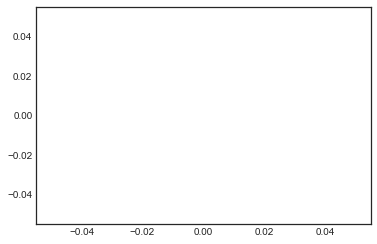

----
 t!f/<vhr.k&7w!_,u16h1â[»&4»4[m[»)»7.fây.£1.g5!â;7n?â)).:[fs6v[y4v6â»x@£.âaâl
%¿>»4.f$¿1âïwq>._eh/!x7h$7[..3.hfv%.[f.,tpfz.h0/.%mfpq?7,..f6.`.â »%¿z[$z.,sp6mvfpïj6?"m6âfpff]>>zz>>e2.%,p,xe.¿`h`6[>.]z:j 
----
iter 0, loss 105.498373


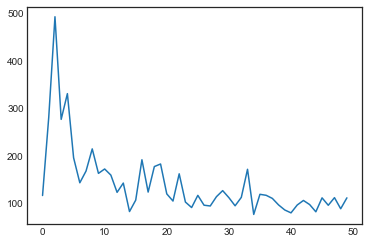

----
 sm  fa me  aamne 
omv moo uhmt my jacmtcmactnouerpa  
lmgelnc h ma marhec vcmacmlrmarmicsna yhmt mycmfajncmlymy aj msrfasmltmec a onrsarmycmacms maama  nemn
m2lc
amacmecmnuhanhhcmemhr
.a mecte hy
natm 
----
iter 50, loss 107.165462


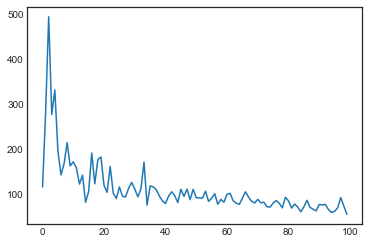

----
 ppv y
syl5sddseja

chhpcesjiyest*4eetreli  9ga

oo
y

cl iyot

cha tlhcen ttcs3coie326defu2esty -ceched7  en8yi s
th 1hdesfe e5see3a3vdswttseaptfr
0r apter 3,d vr3vdsar0edpt
ch lheor3pylav

chllcvec-c 
----
iter 100, loss 105.856806


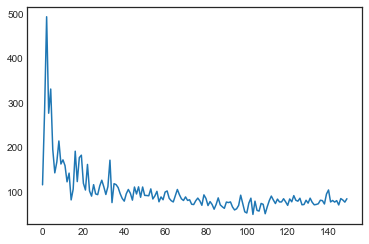

----
 totyb9c,bwr,   yoilal easr ,w d sgs- wa,odgsnam  ansb /noonte da d o  ho  hd rn  ymy  g,o,isb pt sc.sd 4 o  a,od psth. ds oy9 ous, dourruucsswsav facao b sivysrubtma3uus,c nrreof vc i sasta dfhsbnre e 
----
iter 150, loss 104.487140


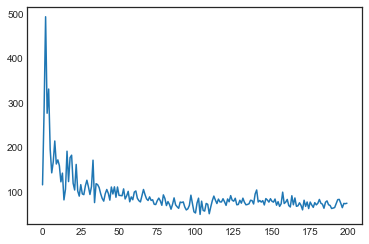

----
 ip tfn,h oo, naoturehcdtpddituy
eit nos o res oi th weekwae ad idd tr oclpr te l eii e
veev
g umpeeidl m le nsrlaor w t xi lpolra tudd 1hweeesrond tdeitlot 



aosuigvjoimguor le et me ge  owd v*ither 
----
iter 200, loss 103.011159


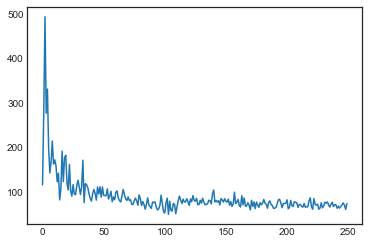

----
  a suutsioiiit c7e l 1hngea m fedenrcmaen he. leri t
dhsvd ly ti ; t thrdled oha; ari 
fsryleep refpo oetin cd adsai and har  mem.
lar, a;ntime aeso  aoig. mostlrb.d afms
tmis  i ksao < mhbererclro, p 
----
iter 250, loss 101.453567


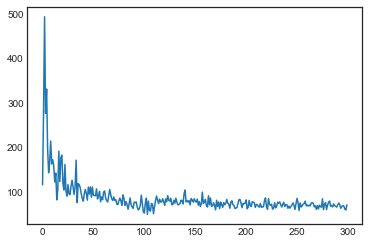

----
  blheulis ot ea
na.me we arclsdyle ants mis

aa t
sedovnme h avilpte sal in hesfc 
y :alfeloryiucwialalsiau, aseke wrerr t af aletca lhel listheenn/rsd elaun isev diu hbth er hassi t my mlthss mi ftis 
----
iter 300, loss 99.930469


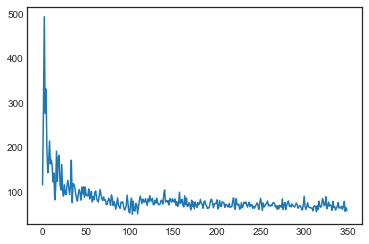

----
 thltaps 2e as
d scs.
lhndly hemilotheton tor phi fu.cti oy oa whinitoadty oqs yoni fe fogn oindny mioth wewdj . cpnt olonda th ahehdyerut a witee
yasewnd we 
cotdrhhusalo owkghle thecptichcn
heru 
eis 
----
iter 350, loss 98.369662


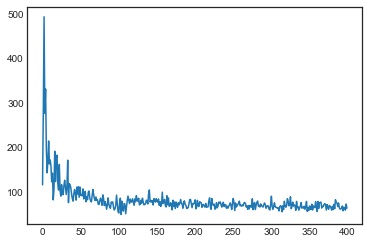

----
 os, meseichaslr who" vesf oera. org a wat. heevseove ses avnef adcw iwtte ialins,ak thet a. hahi f8 a
fp
tus had averotle
stetfuleach iggis at,le
her bat- andi,idhelm, whallerse ma
smas manewwivegctwa 
----
iter 400, loss 96.864313


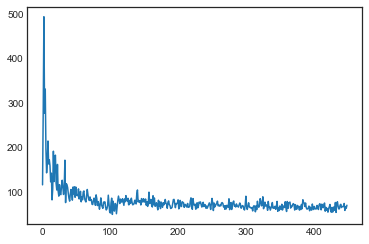

----
  iinge o" ato theale waetomitin wa
le leee psadamo and itomitaconmua inel ha of oust
mand 
"anncgencmaset 7hegft wanle it we din"i alatwans thant wimet
onn
ucthinclrkot-o penser, ao ond silra"taltuc.  
----
iter 450, loss 95.344271


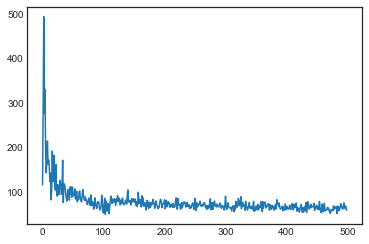

----
 nxrl the med ofed mar, puse torre, fat hoidhacondist to rant vito keceris the on to wimpis

poot na t ponr wof owenxudtd pre nieetthas tol fond itherd ofcc outoude.paburathaefund/et'ut cwd tma, mance  
----
iter 500, loss 93.765945


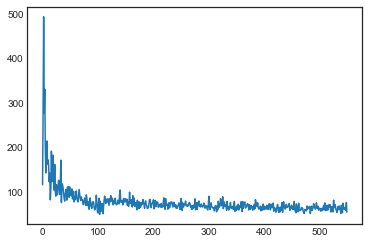

----
  soulh sof on co inlimuenl mis thith.h,as g oser as lasy mlet eri
asoe che to o
engele,steed to icd infmy miscaly bfaad 2. ma, ind so hed ol as cf4 map the mot orbt stcdt
so at and i mane mpeoig and,  
----
iter 550, loss 92.273116


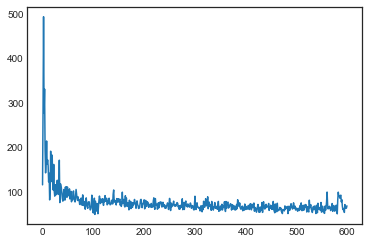

----
 tfcaizrimist it hauihdi pes
" iilhaplt eapdice r sice almethe mit s andt,mre "ita  fo d
o  pree her d alat-eind zton.


ubcod wide tr iai neam cofeentleulet ngimst
chi meing 'ndldimyunticjlimxt dle on 
----
iter 600, loss 91.138105


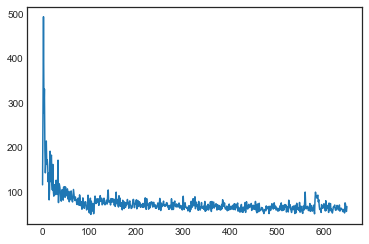

----
 icloirla pleitis thistetpo gobe 4os verstosbmetwy mnprhen fit den. thellepbulatube megabr.itos yraegb anvit io  ho nondeqbo5 thands y
sheleche the ternl wowarus oro<ao alit qubreerte. opr ope abdprmed 
----
iter 650, loss 89.810859


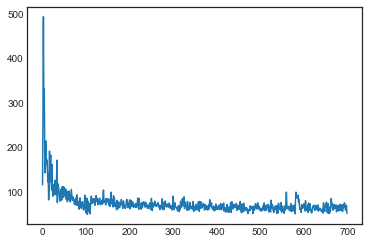

----
 astaisabeas? af wi, i
"mth makly  ounwth ncy
mlves sas
ci? the hmac mounket t ao ly dit eof rys appous mtneed? penae friede uid is avcmecot-wit
"nt,"is brumacebn mosrenmcig.
mit,"ani.
the ioibc tn jhi 
----
iter 700, loss 88.586590


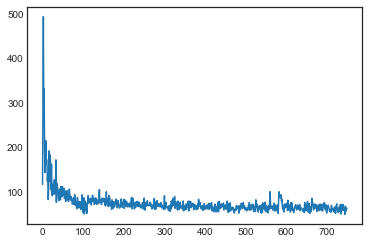

----
 b, int, tem ren w
in thiverd of uyd renit hetiso uen veapnolg hanonslycek in thet of afand, theof aomusy., eve diest ikn ofund i,,"o sexprocverelsthit has, tintgnge "ignifce ne has thathe fome ceilart 
----
iter 750, loss 87.246312


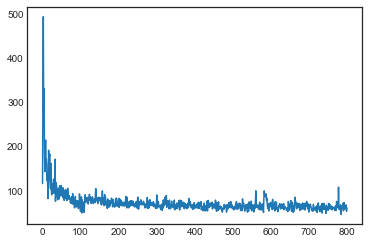

----
  of ias ang cous ptsmebb ourit nof phis s oras d co  ungsuronghah sof wastg heid, he annpwacdets--worethin wis yeg sis hit laind, to whimnacure ce one my riusr -my pf a hig horisclfhsnt-and thh is has 
----
iter 800, loss 86.072763


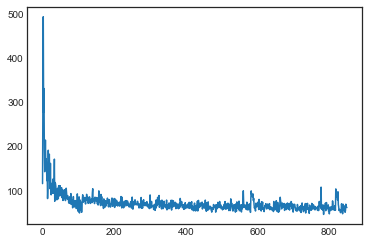

----
 y iw my" oy re il igit inid,
"okpekg 3 mey ofider rourecle ti n
sh mone abn m. sodmepthe.
i d
aniw at lhimy soggenull,
"g.
maf anty pre, apsc letin
er hit 
eex wa<gto, i bocalus si ws sulis." hi t: i  
----
iter 850, loss 85.014167


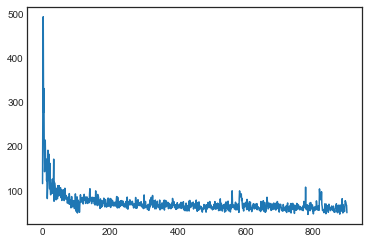

----
  ry>pinn? bid h thetheris o wme.ir. the, igong hintteit theund buftind arten  hebe that stheth wee bing homy, hewishtukn ittecoo k fiak<?" hogit, woue, tott< <ethe megy, whec>-phy poco ththe ir-lighai 
----
iter 900, loss 83.856366


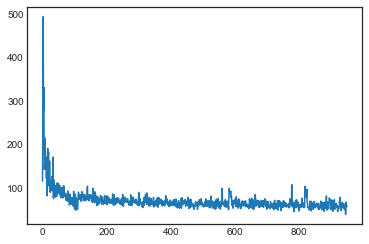

----
 y
hi
cha>d whe my dith bagwoave
d my whein /ichoriv
in, wourme in the ab
<i a w, ih quth
fhaanmy gi>n!
ap, rimacecn miniclutd my wrfack li>ed the thet mer
w
thicransna, af wery. ayry che libd leand
ac 
----
iter 950, loss 82.666447


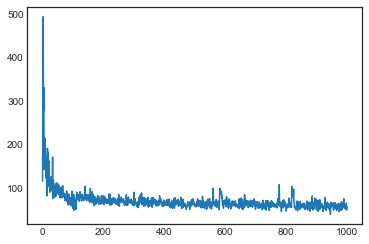

----
 leterd.

"fangic; mbed so pnosed my ed oumllery
coproheurd hot hy poreit; she we lowtound anttheres ount, thek sheam.

w<i)cf-/i thom 0and aptrong
iccecea, l mothong hy sile,

"riby nre my gaon hougar 
----
iter 1000, loss 81.526390


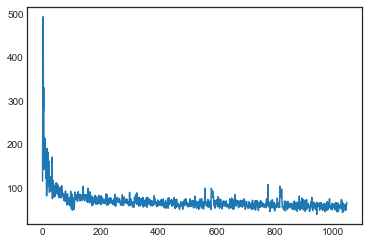

----
 ibeut ins-fiy mat locele ikurczer
has up wiucly huree gtnichakmhit he mua ins he warsshe inima abrhpatt no en i pa deluvomen w udg, hiblle.


hamso le has phourgrecert

i wervinnfhercle pontinger wrei 
----
iter 1050, loss 80.377171


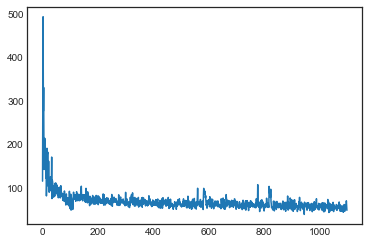

----
 to meriwh by him sone thiowke the ce go wisss. acgecokllead heat fe wensenle cosisiman to astiin io dikle hat the fis co capist wimincey tont sfincko owowig.s
hive dit fisigus. be wim, mever i in ing  
----
iter 1100, loss 79.188261


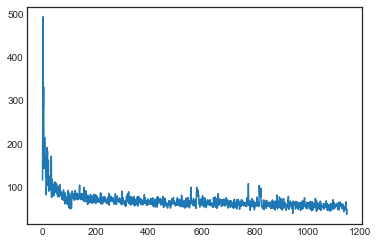

----
 ueron my mutclumuancof cong. g the feadle the frad my ed. nost tomy thaventt, thin watd of lataf wak wouteng. foklotis hat him shakt y ssomy me thind dily thind and paor
veme woruting the tin'onkeck s 
----
iter 1150, loss 78.018813


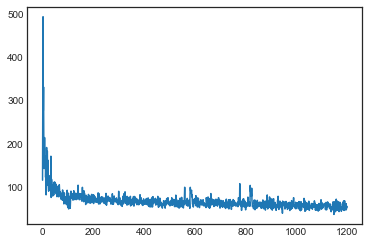

----
 i wo the beof irxoskiedroto- tor weok.
 overerjoithen pre meer and keovered thimset, arpkle.


mughat porleneded.
to verould torked.

wupkeckeae. aspirele fary not my <dound nould" on a per shanh thic 
----
iter 1200, loss 76.955022


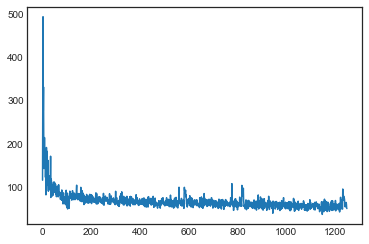

----
 femedec was rephlart.

 trel'en mach whround selall doree he cenld to facgbeo it rot loeesallund of elusclit ar cave ande suthit intemely isul.

"r cne harr soudhars
ed
ive suas ut "ta has  d,




w c 
----
iter 1250, loss 76.144682


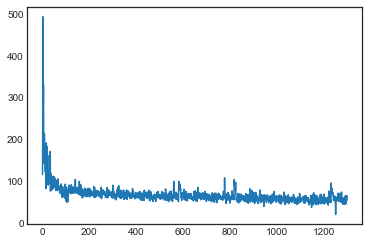

----
 . ory ro borisel lorarand chang at thtowas it
muthinsenved!ry,
oassme thindy:cues nom
zorote kexeortthas ther ineshe icoly in emawe. had my tho or tandluneastmenperleitercioulmang, uud ofe et. of
maan 
----
iter 1300, loss 75.169763


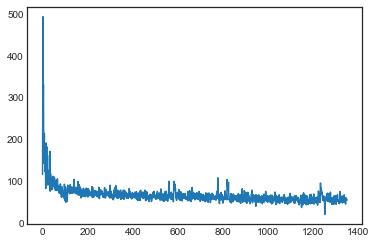

----
 ot vuor deeltuy the tt; my jouttid to hic onoliuleliath ouncly wabtche muld agud."

"but vikiry, hi meavered han of youct is ledisut oneryt ab thied rohofincler, on silell ap dith
athe ler, the mmot.o 
----
iter 1350, loss 74.226889


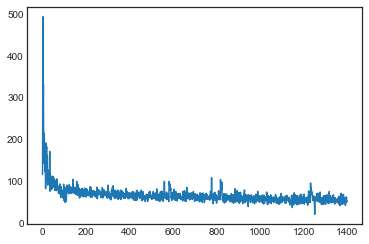

----
 red or thme ast norocr,? fonhtied heannemeced andam.

"the roy is with kovortt
"feetor fattonuro atl samf
hion cat collesantanot to wastponolinlucnesterilienfand gan the shar caturdi

handotoult.

"ma 
----
iter 1400, loss 73.271263


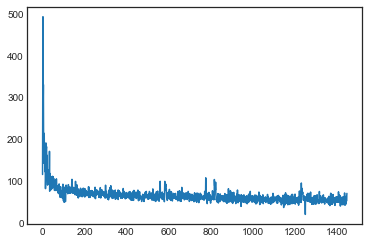

----
  fti fat s exte bece. bulverisis, ffof
deed a sick--andsen, it in fither. wat
fad able and kfis, awpolienses."

"e osee the yond in andd yough beucfeftir rot! and there, di salukay ouenb: in ar. deout 
----
iter 1450, loss 72.361418


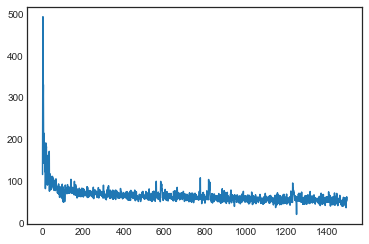

----
 fa
hepat thith isnsn
jye fies."

"weincgtini--un coat is in by woupyouns,"

sis," i nom we, prad.

"nos whoun,

"whrmune hesyet raderere. efseut i qurdtred isarigh experussne kinst as prcond sele, ime 
----
iter 1500, loss 71.394624
SIGINT received. Delaying KeyboardInterrupt.


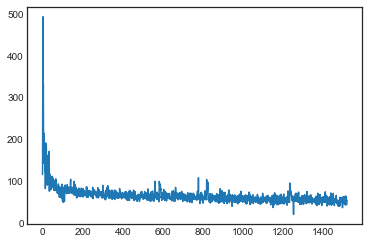

----
 scorncenn. "deer phateres."

"heng5
teath the aceven dexceroste noferemp.

"wit ast to puttte wolporonl, whim be of
set caiant at owe ubesurrosmebe cad."

"prasos a to scretter rosut exvernon ifatont  
----
iter 1518, loss 71.066252


In [17]:
while True:
    try:
        with DelayedKeyboardInterrupt():
            # Reset
            if pointer + T_steps >= len(data) or iteration == 0:
                g_h_prev = np.zeros((H_size, 1))
                g_C_prev = np.zeros((H_size, 1))
                pointer = 0


            inputs = ([char_to_idx[ch] 
                       for ch in data[pointer: pointer + T_steps]])
            targets = ([char_to_idx[ch] 
                        for ch in data[pointer + 1: pointer + T_steps + 1]])

            loss, g_h_prev, g_C_prev = \
                forward_backward(inputs, targets, g_h_prev, g_C_prev)
            smooth_loss = smooth_loss * 0.999 + loss * 0.001

            # Print every hundred steps
            if iteration % 50 == 0:
                update_status(inputs, g_h_prev, g_C_prev)

            update_paramters()

            plot_iter = np.append(plot_iter, [iteration])
            plot_loss = np.append(plot_loss, [loss])

            pointer += T_steps
            iteration += 1
    except KeyboardInterrupt:
        update_status(inputs, g_h_prev, g_C_prev)
        break

In [26]:
# Printing generated text from random input character

sample_idx = generate_next_char(g_h_prev, g_C_prev, inputs[10], 200)
txt = ''.join(idx_to_char[idx] for idx in sample_idx)

print(txt)


rod is aplyts, my mat-
inther the , torea. soll repaporusrent. ant of dour alless feash the the mone all of the soin the thoge voofe jtentoantenes, not recaroly dovere mem" aly beary texpetorre the ul


Performing Gradient check

In [19]:
from random import uniform

# Calculate numerical gradient
def calc_numerical_gradient(param, idx, delta, inputs, target, h_prev, C_prev):
    old_val = param.v.flat[idx]
    
    # evaluate loss at [x + delta] and [x - delta]
    param.v.flat[idx] = old_val + delta
    loss_plus_delta, _, _ = forward_backward(inputs, targets,
                                             h_prev, C_prev)
    param.v.flat[idx] = old_val - delta
    loss_mins_delta, _, _ = forward_backward(inputs, targets, 
                                             h_prev, C_prev)
    
    param.v.flat[idx] = old_val #reset

    grad_numerical = (loss_plus_delta - loss_mins_delta) / (2 * delta)
    # Clip numerical error because analytical gradient is clipped
    [grad_numerical] = np.clip([grad_numerical], -1, 1) 
    
    return grad_numerical

In [20]:
# Check gradient of each paramter matrix/vector at `num_checks` individual values
def gradient_check(num_checks, delta, inputs, target, h_prev, C_prev):
    global parameters
    
    # To calculate computed gradients
    _, _, _ =  forward_backward(inputs, targets, h_prev, C_prev)
    
    
    for param in parameters.all():
        #Make a copy because this will get modified
        d_copy = np.copy(param.d)

        # Test num_checks times
        for i in range(num_checks):
            # Pick a random index
            rnd_idx = int(uniform(0, param.v.size))
            
            grad_numerical = calc_numerical_gradient(param,
                                                     rnd_idx,
                                                     delta,
                                                     inputs,
                                                     target,
                                                     h_prev, C_prev)
            grad_analytical = d_copy.flat[rnd_idx]

            err_sum = abs(grad_numerical + grad_analytical) + 1e-09
            rel_error = abs(grad_analytical - grad_numerical) / err_sum
            
            # If relative error is greater than 1e-06
            if rel_error > 1e-06:
                print('%s (%e, %e) => %e'
                      % (param.name, grad_numerical, grad_analytical, rel_error))

In [21]:
gradient_check(10, 1e-5, inputs, targets, g_h_prev, g_C_prev)

W_f (-5.127596e-05, -5.127647e-05) => 4.934932e-06
W_f (-6.284750e-07, -6.288828e-07) => 3.240236e-04
W_f (1.470646e-05, 1.470659e-05) => 4.613070e-06
W_f (7.389644e-08, 7.351141e-08) => 2.594439e-03
W_i (-1.980379e-04, -1.980373e-04) => 1.377226e-06
W_i (3.694822e-07, 3.696888e-07) => 2.791208e-04
W_i (1.421085e-09, 1.214865e-09) => 5.671696e-02
W_i (4.965628e-06, 4.965451e-06) => 1.779200e-05
W_C (8.313350e-08, 8.282205e-08) => 1.865473e-03
W_C (-1.579181e-06, -1.578425e-06) => 2.394697e-04
W_o (7.992185e-06, 7.991578e-06) => 3.794839e-05
W_o (1.036490e-04, 1.036487e-04) => 1.287496e-06
W_o (-6.890133e-06, -6.889758e-06) => 2.719496e-05
W_v (-2.472689e-06, -2.472735e-06) => 9.309999e-06
W_v (8.418866e-06, 8.418283e-06) => 3.457916e-05
W_v (-7.981171e-06, -7.980558e-06) => 3.840423e-05
W_v (-4.356409e-05, -4.356472e-05) => 7.302330e-06
W_v (-6.394885e-09, -6.656277e-09) => 1.860288e-02
b_f (3.782930e-06, 3.782604e-06) => 4.306524e-05
b_f (1.204370e-06, 1.204379e-06) => 3.846637e-06
b_

Analysis -> I have tried this model using 50, 100 and 200 hidden units but the graphs do not show any major difference. Only the graph with 200 hidden units shows more fluctuations. Also I have tried input seqiuence length as 25 and 50.